In [1]:
import csv
import numpy as np
import utils
import hrr_utils
import time


from scipy import spatial
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
%matplotlib inline

N=1000

def genX(verbs):
    X = np.zeros((len(verbs), N)) # Exclusively difference PAST1-PRES1
    PRES1 = np.zeros((len(verbs), N))
    PRES2 = np.zeros((len(verbs), N))
    PAST1 = np.zeros((len(verbs), N))
    PAST2 = np.zeros((len(verbs), N))

    for m, pair in enumerate(verbs):
        past1 = hrr_utils.GetRVClipHash(pair[1], dic1, 3)
        past2 = hrr_utils.GetRVClipHash(pair[1], dic2, 3)
        pres1 = hrr_utils.GetRVClipHash(pair[0], dic1, 3)
        pres2 = hrr_utils.GetRVClipHash(pair[0], dic2, 3)
        PRES1[m] = pres1
        PRES2[m] = pres2
        PAST1[m] = past1
        PAST2[m] = past2

    #X = np.where(PAST1-PRES1 > 0, 1, -1)
    X = PAST1-PRES1
    return X, PRES1, PRES2, PAST1, PAST2


def closed_train(Past, Present):
    return np.dot(np.linalg.pinv(Present), Past)

# HD Algo
def train(W, past, present):
    # col x row
    W += np.outer(present, past)
    return W

def train_diff(W, past2, present1, present2):
    W += np.outer(present1, past2-present2)
    return W

def sim(x, y):
    if len(x.shape) == 1 or len(y.shape)==1:
        return np.dot(x, y)
    return np.sum(np.multiply(x, y), axis=1)


def graphstd(x, y1, y2, y1std, y2std, title=None, xlabel='number of words', ylabel='average dot product', legend='upper right'):
    
    fig = plt.figure(figsize=(4,3))
    plt.plot([0, 1700], [0, 0], 'k')

    plt.plot(x, y1, c='b', lw=2, label='Train')
    plt.plot(x, y2, c='g', lw=2, label='Test')

    plt.fill_between(x, y1-y1std, y1+y1std, facecolor='b', alpha=0.1)
    plt.fill_between(x, y2-y2std, y2+y2std, facecolor='g', alpha=0.1)

    plt.legend(loc=legend)

    plt.xlabel('Number Training Examples')
    plt.ylabel('Feature Similarity')
    plt.title(title)

    plt.xlim([0, 1700])
    plt.tight_layout()
    
def graph(x, y1, y2, title=None, xlabel='number of words', ylabel='average dot product', legend='upper right'):

    fig = plt.figure(figsize=(4,3))
    plt.plot(x, y1, label="train")
    plt.plot(x, y2, label="test")
    fig.suptitle(title, fontsize=20)
    plt.xlabel(xlabel, fontsize=18)
    plt.ylabel(ylabel, fontsize=16)
    plt.legend(loc=legend)
    plt.show()
    #fig.savefig('test.jpg')

In [2]:
reg_pres, reg_past, reg_freq = utils.GetRegularVerbs(frequency=1)
irreg_pres, irreg_past, irreg_freq = utils.GetIrregularVerbs(frequency=1)

data_size = len(reg_pres)
reg_pres, reg_past, reg_freq = reg_pres[:data_size], reg_past[:data_size], reg_freq[:data_size]
irreg_pres, irreg_past, irreg_freq = irreg_pres[:data_size], irreg_past[:data_size], irreg_freq[:data_size]

regular = zip(reg_pres, reg_past, reg_freq)
irregular = zip(irreg_pres, irreg_past, irreg_freq)

train_cutoff = 1700

train_reg = regular[0:train_cutoff]
train_irreg = irregular[0:train_cutoff]


test_reg = regular[train_cutoff:]
test_irreg = irregular[train_cutoff:]

dic1 = hrr_utils.GenerateDefaultDictionary(N)
dic2 = hrr_utils.GenerateDefaultDictionary(N)

regular.extend(irregular)
verbs = regular

In [3]:
trainX, trainpres1, trainpres2, trainpast1, trainpast2 = genX(train_reg + train_irreg)
testX, testpres1, testpres2, testpast1, testpast2 = genX(test_reg + test_irreg)

In [58]:
x = np.arange(1, trainpres1.shape[0], 10)
print x

[  1  11  21  31  41  51  61  71  81  91 101 111 121 131]


figures/regression-unregularized_closedform-trigram-N=1000-W=1889-170428


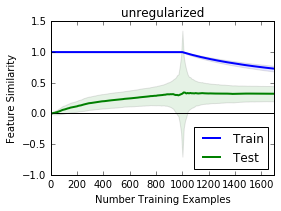

In [20]:
x = np.arange(1, trainpres1.shape[0], 10)
y1 = np.zeros(x.shape[0])
y2 = np.zeros(x.shape[0])
y1std = np.zeros(x.shape[0])
y2std = np.zeros(x.shape[0])


for i in range(x.shape[0]):#trainpres1.shape[0]):
    k = x[i]
    W = closed_train(trainpast2[:k], trainpres1[:k])
    train_pred = trainpres1[:k].dot(W)
    test_pred = testpres1.dot(W)

    sim1 = sim(train_pred, trainpast2[:k])
    sim2 = sim(test_pred, testpast2)
    
    y1[i] = sim1.mean()/N
    y1std[i] = np.nanstd(sim1, axis=0)/N
    y2[i] = sim2.mean()/N
    y2std[i] = np.nanstd(sim2, axis=0)/N

    
graphstd(x,y1,y2,y1std,y2std,"unregularized", legend="lower right")

fname =  ('figures/regression-unregularized_closedform-trigram-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)


figures/regression-unregularized_closedform-trigram-N=1000-W=1889-170428


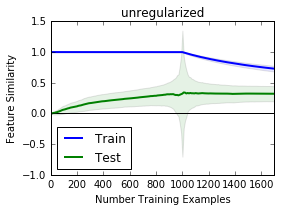

In [21]:
graphstd(x,y1,y2,y1std,y2std,"unregularized", legend="lower left")

fname =  ('figures/regression-unregularized_closedform-trigram-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

figures/regression-diff_unregularized_closedform_trigam-N=1000-W=1889-170430


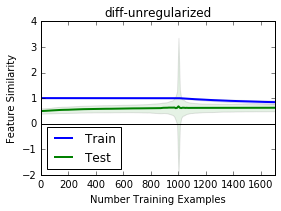

In [9]:
x = np.arange(1, trainpres1.shape[0], 10)
y1 = np.zeros(x.shape[0])
y2 = np.zeros(x.shape[0])
y1std = np.zeros(x.shape[0])
y2std = np.zeros(x.shape[0])

for i in range(x.shape[0]):#trainpres1.shape[0]):
    k = x[i]
    W = closed_train(trainpast2[:k]-trainpres2[:k], trainpres1[:k])
    train_pred = trainpres1[:k].dot(W) + trainpres2[:k]
    test_pred = testpres1.dot(W) + testpres2

    sim1 = sim(train_pred, trainpast2[:k])
    sim2 = sim(test_pred, testpast2)
    
    y1[i] = sim1.mean()/N
    y1std[i] = np.nanstd(sim1, axis=0)/N
    y2[i] = sim2.mean()/N
    y2std[i] = np.nanstd(sim2, axis=0)/N
    
graphstd(x,y1,y2,y1std,y2std,"diff-unregularized", legend="lower left")

fname =  ('figures/regression-diff_unregularized_closedform_trigam-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

figures/regression-diff_unregularized_closedform_trigam-N=1000-W=1889-170428


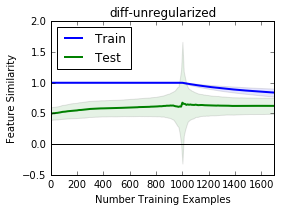

In [19]:
graphstd(x,y1,y2,y1std,y2std,"diff-unregularized", legend="upper left")

fname =  ('figures/regression-diff_unregularized_closedform_trigam-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

figures/regression-unregularized_outer_trigam_dict-N=1000-W=1889-170428


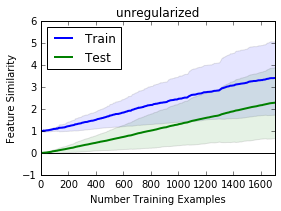

In [65]:
W = np.zeros((N,N))
W = train(W, trainpast2[0], trainpres1[0])
random_vecs = np.random.randn(testpast2.shape[0], N)
x = np.arange(1, trainpres1.shape[0], 1)
y1 = np.zeros(x.shape[0])
y2 = np.zeros(x.shape[0])

y1std = np.zeros(x.shape[0])
y2std = np.zeros(x.shape[0])
for i in range(x.shape[0]):
    k = x[i]
    train_pred = W.T.dot(trainpres1[:k].T).T
    test_pred = W.T.dot(testpres1.T).T

    sim1 = sim(train_pred, trainpast2[:k])
    sim2 = sim(test_pred, testpast2)
    
    y1[i] = sim1.mean()/N**2
    y1std[i] = np.nanstd(sim1, axis=0)/N**2
    y2[i] = sim2.mean()/N**2
    y2std[i] = np.nanstd(sim2, axis=0)/N**2
    
    W = train(W, trainpast2[k], trainpres1[k])

graphstd(x,y1,y2,y1std,y2std,"unregularized", legend="upper left")

fname =  ('figures/regression-unregularized_outer_trigam_dict-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname
plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)


In [70]:
def reg_train(W, Past, Present):
    pred = np.dot(W, Present)
    W += ((N*N-sim(pred, Past))/float(N*N)) * np.outer(Past, Present)
    return W

figures/regression-regularized_outer_trigam_dict-N=1000-W=1889-170428


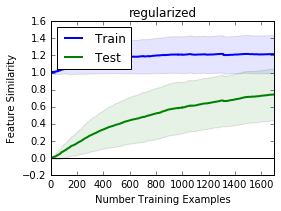

In [71]:
W = np.zeros((N,N))
W = reg_train(W, trainpast2[0], trainpres1[0])

x = np.arange(1, trainpres1.shape[0], 1)
y1 = np.zeros(x.shape[0])
y2 = np.zeros(x.shape[0])
y1std = np.zeros(x.shape[0])
y2std = np.zeros(x.shape[0])

for i in range(x.shape[0]):
    k = x[i]
    #train_pred = W.T.dot(trainpres1[:k].T).T
    #test_pred = W.T.dot(testpres1.T).T
    
    train_pred = np.dot(W, trainpres1[:k, :].T).T
    test_pred = np.dot(W, testpres1.T).T
    
    sim1 = sim(train_pred, trainpast2[:k])
    sim2 = sim(test_pred, testpast2)
    
    y1[i] = sim1.mean()/N**2
    y1std[i] = np.nanstd(sim1, axis=0)/N**2
    y2[i] = sim2.mean()/N**2
    y2std[i] = np.nanstd(sim2, axis=0)/N**2
    
    W = reg_train(W, trainpast2[k], trainpres1[k])
    
graphstd(x,y1,y2,y1std,y2std,"regularized",legend="upper left")

fname =  ('figures/regression-regularized_outer_trigam_dict-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname
plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)


figures/regression-regularized_outer_trigam_dict-N=1000-W=1889-170428


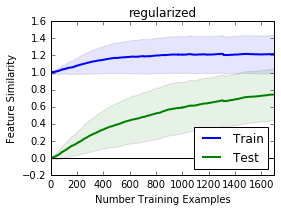

In [72]:
graphstd(x,y1,y2,y1std,y2std,"regularized",legend="lower right")

fname =  ('figures/regression-regularized_outer_trigam_dict-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname
plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)


figures/regularized_outer_trigam_dict-N=1000-W=1889-170428


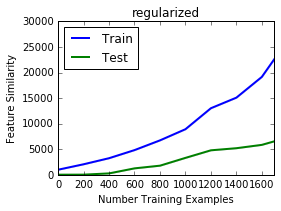

In [46]:
# why would changing the order of the transposing change the results?
# which cell is correct? cell 56 or cell 57?
W = np.zeros((N,N))
W = reg_train(W, trainpast2[0], trainpres1[0])
random_vecs = np.random.randn(testpast2.shape[0], N)
x = np.arange(1, trainpres1.shape[0], 1)
y1 = np.zeros(x.shape[0])
y2 = np.zeros(x.shape[0])

y1 = np.zeros(x.shape[0])
y2 = np.zeros(x.shape[0])

for i in range(x.shape[0]):
    k = x[i]
    #train_pred = W.T.dot(trainpres1[:k].T).T
    #test_pred = W.T.dot(testpres1.T).T
    
    train_pred = np.dot(W, trainpres1[:k, :].T)
    test_pred = np.dot(W, testpres1.T)
    
    y1[i] = sim(train_pred, trainpast2[:k, :].T).mean()
    y2[i] = sim(test_pred, testpast2.T).mean()
    
    W = reg_train(W, trainpast2[k], trainpres1[k])

graph(x,y1,y2,y1std,y2std,title='regularized', legend='upper left')

fname =  ('figures/regularized_outer_trigam_dict-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname
# plt.savefig(fname + '.png', transparent=True)
# plt.savefig(fname + '.eps', transparent=True)

# change location/ add location parameter for legend

In [73]:
W = np.zeros((N,N))
W = train_diff(W, trainpast2[0], trainpres1[0], trainpres2[0])

x = np.arange(1, trainpres1.shape[0], 1)
y1 = np.zeros(x.shape[0])
y2 = np.zeros(x.shape[0])

y1std = np.zeros(x.shape[0])
y2std = np.zeros(x.shape[0])
for i in range(x.shape[0]):#trainpres1.shape[0]):
    k = x[i]
    train_pred = trainpres1[:k].dot(W)
    #train_pred = np.where(train_pred>0, 1, -1)
    test_pred = testpres1.dot(W)
    #test_pred = np.where(test_pred>0, 1, -1)
    
    train_pred = W.T.dot(trainpres1[:k].T).T + trainpres2[:k]*N
    test_pred = W.T.dot(testpres1.T).T + (testpres2*N)
    
    #y1[i] = sim(train_pred/float(N), trainpast2[:k]).mean()
    #y2[i] = sim(test_pred/float(N), testpast2).mean()
    
    sim1 = sim(train_pred, trainpast2[:k])
    sim2 = sim(test_pred, testpast2)
    
    y1[i] = sim1.mean()/N**2
    y1std[i] = np.nanstd(sim1, axis=0)/N**2
    y2[i] = sim2.mean()/N**2
    y2std[i] = np.nanstd(sim2, axis=0)/N**2
    
    W = train_diff(W, trainpast2[k], trainpres1[k], trainpres2[k])

graphstd(x,y1,y2,y1std,y2std,title='diff-unregularized', legend='lower right')

fname =  ('figures/regression-diff_unregularized_outer_trigam_dict-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

TypeError: graph() got multiple values for keyword argument 'title'

figures/regression-diff_unregularized_outer_trigam_dict-N=1000-W=1889-170428


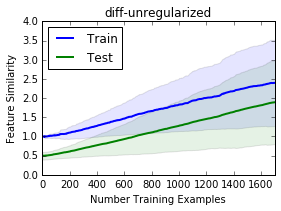

In [75]:
graphstd(x,y1,y2,y1std,y2std,title='diff-unregularized', legend='upper left')

fname =  ('figures/regression-diff_unregularized_outer_trigam_dict-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

In [7]:
def reg_train_diff(W, past2, present1, present2):
    #W.T.dot(trainpres1[:k].T).T + trainpres2[:k]*N
    pred = np.dot(W, present1) + present2*N
    W += ((N*N-sim(pred, past2))/float(N*N)) * np.outer(present1, past2-present2)
    return W

figures/regression-diff_regularized_outer_trigam_dict-N=1000-W=1889-170430


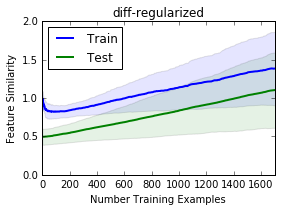

In [8]:
W = np.zeros((N,N))
W = reg_train_diff(W, trainpast2[0], trainpres1[0], trainpres2[0])
random_vecs = np.random.randn(testpast2.shape[0], N)
x = np.arange(1, trainpres1.shape[0], 1)
y1 = np.zeros(x.shape[0])
y2 = np.zeros(x.shape[0])

y1std = np.zeros(x.shape[0])
y2std = np.zeros(x.shape[0])

for i in range(x.shape[0]):#trainpres1.shape[0]):
    k = x[i]

    train_pred = W.T.dot(trainpres1[:k].T).T + trainpres2[:k]*N
    test_pred = W.T.dot(testpres1.T).T + (testpres2*N)
    
    #print (train_pred.shape, test_pred.shape)
#     y1[i] = sim(train_pred/float(N), trainpast2[:k]).mean()
#     y2[i] = sim(test_pred/float(N), testpast2).mean()
    
    sim1 = sim(train_pred, trainpast2[:k])
    sim2 = sim(test_pred, testpast2)
    
    y1[i] = sim1.mean()/N**2
    y1std[i] = np.nanstd(sim1, axis=0)/N**2
    y2[i] = sim2.mean()/N**2
    y2std[i] = np.nanstd(sim2, axis=0)/N**2
      
    W = reg_train_diff(W, trainpast2[k], trainpres1[k], trainpres2[k])

graphstd(x,y1,y2,y1std,y2std,title='diff-regularized', legend='upper left')

fname =  ('figures/regression-diff_regularized_outer_trigam_dict-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)